In [54]:
        import tensorflow
        import numpy
        import skimage.io as scikit_io
        import skimage.transform as scikit_transform
        import matplotlib.pyplot as matplot_plot
        import matplotlib.image as matplot_image
        import sklearn.model_selection as scikit_model_selection
        import os

        LEARNING_RATE = 0.0001
        EPOCHS = 100
        BATCH_SIZE = 10

        INPUT_SIZE = 128

# Image Loading

In [55]:
        def load_image(path):
            image = scikit_io.imread(path)
            return scikit_transform.resize(image, (INPUT_SIZE, INPUT_SIZE), anti_aliasing = True)

        def show_image(image):
            matplot_plot.imshow(image)
            matplot_plot.axis('off')

In [56]:
def load_directory(directory):
    images = []
    for image_path in os.listdir(directory):
        if (image_path.endswith(".png")):
            images.append(load_image(os.path.join(directory, image_path)))
    return images

In [57]:
#scikit_model_selection.train_test_split()
images = load_directory("../image-puller/images/men")

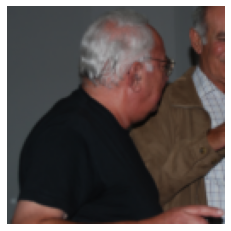

In [71]:
show_image(images[0])

In [76]:
def create_model():
    input_layer = tensorflow.reshape(images[0], shape=[-1, INPUT_SIZE, INPUT_SIZE, 3])
    convolution = []
    convolution.append(
        tensorflow.keras.layers.Conv2D(8, (6, 6), 1, )
    ) 


In [77]:
create_model()

AttributeError: module 'tensorflow' has no attribute 'layers'